#### Part 1: A discrete-time model

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

from scipy.stats import t
from scipy import stats
np.random.seed(42)


We are following the Markov model in order to model discrete time. Thw model follows women after they had their breast tumor removed. The cancer may reappear close to the removed tumor. The probability of the tumor recurances are following the 5 states:

0: Post-surgery (initial state)

1: Local recurrence

2: Distant metastasis

3: Both local and distant

4: Death (absorbing state — once entered, cannot leave)

We simulate 1000 women each state 0. One step = 1 month. Stop simulation when patient reaches state 4. 


Assume that one time step equals one month. Simulate 1000 women, all
starting in state 1, until death. Summarize the lifetime distribution of the
women, after surgery, for example using a histogram. In what proportion of
women does the cancer eventually reappear, locally?

In [ ]:
n = 1000 # no. of women to simulate

# The probability matrix (P)
P = np.array([[0.9915, 0.005, 0.0025, 0, 0.001],
              [0, 0.986, 0.005, 0.004, 0.005],
              [0, 0, 0.992, 0.003, 0.005],
              [0, 0, 0, 0.991, 0.009], 
              [0, 0, 0, 0, 1]])

# Simulation for a single patient
def simulate_patient(P, X0=0): # X0 = 0 - All start in state 0 (Healthy)
    state = X0
    seq_state = [state] # list to record all the states the patient visits during the simulation. patient starts in state so thats added first. New states will be appended to this list — each representing the patient's next health state at the next month.
    while state !=4:
        state = np.random.choice(range(0,5), p=P[state])
        seq_state.append(state)
    return seq_state

test_path = simulate_patient(P)
#print(test_path[0])
#print(test_path[-1])

# Simulate all 1000 patients
all_patient_journey = [] # list of 1000 lists — one per patient

for _ in range(n):
    patient_journey = simulate_patient(P)
    all_patient_journey.append(patient_journey)

lifetimes = []          # no. of transitions until death (in months)
local_recurrences = 0   # counter for how many had local recurrence (state 1)

for journey in all_patient_journey:
    lifetime = len(journey) - 1 # exclude initial state
    lifetimes.append(lifetime)

    if 1 in journey: # Check if patient ever visited state 1 (local recurrence)
        local_recurrences +=1

# Compute the proportion of patients who had local recurrence
proportion_local_recurrence = local_recurrences / n
print(f"The proportion of women with local recurrence is: {proportion_local_recurrence:.4f}")
# variance


The proportion of women with local recurrence is: 0.5890


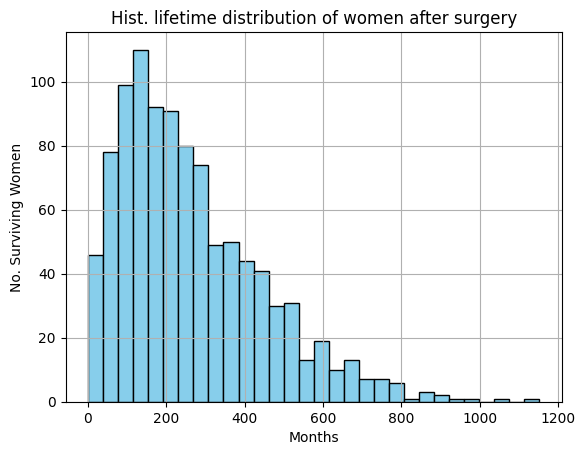

In [48]:
import matplotlib.pyplot as plt

plt.hist(lifetimes, bins=30, color='skyblue', edgecolor='black')
plt.title("Hist. lifetime distribution of women after surgery")
plt.xlabel("Months")
plt.ylabel("No. Surviving Women")
plt.grid(True)
plt.show()

Simulations can be validated by ensuring they are consistent with analytical
results. One way to do this, is to ensure the distribution over the states at a
certain time is consistent with what we expect.

#### Analytical solution

find the empirical distribution of $X_{120}$. This is compared to the theoretical distribution $$ p_{t} = p_{o} * p^{t}$$

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Parameters
n = 1000
t = 120  # Month at which to evaluate distributions

# Transition matrix
P = np.array([
    [0.9915, 0.005, 0.0025, 0.0,    0.001],
    [0.0,    0.986, 0.005,  0.004,  0.005],
    [0.0,    0.0,   0.992,  0.003,  0.005],
    [0.0,    0.0,   0.0,    0.991,  0.009],
    [0.0,    0.0,   0.0,    0.0,    1.0]
])

# Simulation function up to time t
def simulate_patient_fixed_t(P, t=120, X0=0):
    state = X0
    for _ in range(t):
        if state == 4:  # death
            break
        state = np.random.choice(range(5), p=P[state])
    return state

# Simulate final states of all patients at time t
#final_states = [simulate_patient_fixed_t(P, t=t) for _ in range(n)]

final_states = []
for _ in range(n):
    state = simulate_patient_fixed_t(P, t=t) # Simulate one patient up to time t
    final_states.append(state)

# Empirical distribution
counts = Counter(final_states)
empirical_distribution = [counts.get(i, 0) / n for i in range(5)]

# Theoretical distribution using matrix exponentiation
p0 = np.array([1, 0, 0, 0, 0])
Pt = np.linalg.matrix_power(P, t)
theoretical_distribution = np.dot(p0, Pt)


In [57]:
print(f"{'State':<10}{'Empirical':<15}{'Theortical':<15}")
for i in range(5):
    state = f"State {i}"
    emp = round(empirical_distribution[i], 4)
    theo = round(theoretical_distribution[i], 4)
    print(f"{state:<10} {emp:<15} {theo:<15}")


State     Empirical      Theortical     
State 0    0.365           0.359          
State 1    0.149           0.159          
State 2    0.16            0.1661         
State 3    0.071           0.0677         
State 4    0.255           0.2482         


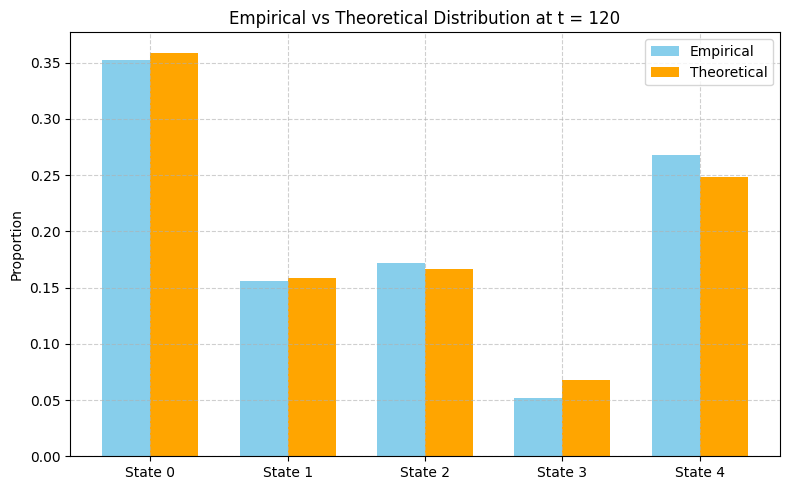

In [59]:

# Plotting
labels = [f"State {i}" for i in range(5)]
x = np.arange(len(labels))

plt.figure(figsize=(8, 5))
bar_width = 0.35
plt.bar(x - bar_width/2, empirical_distribution, bar_width, label="Empirical", color='skyblue')
plt.bar(x + bar_width/2, theoretical_distribution, bar_width, label="Theoretical", color='orange')

plt.xticks(x, labels)
plt.ylabel("Proportion")
plt.title("Empirical vs Theoretical Distribution at t = 120")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

We can use a $\chi^2$-test and obtain a test statistic which can then be compared with a $\chi^2$ distribution with $df = n_{\mathrm{classes}} - 1$ degrees of freedom. 

$$
T = \sum^{n_{\mathrm{classes}}}_{i=1} \frac{ ( n_{\mathrm{observed},i} - n_{\mathrm{expected},i} )^2 }{ n_{\mathrm{expected},i} }
$$

We make the following observations:
- If $\chi^2_{observed}>\chi^2_{critical}$ we can reject the null hypothesis that the two samples come from the same distribution.
- The p-value in the context of a $\chi^2$ test represents the probability of observing a $\chi^2$ statistic as extreme as, or more extreme than, the observed value under the null hypothesis.


In [50]:
from scipy.stats import chi2

#### $\chi^2$-test: Direct method

In [ ]:
# Total number of patients
n = 1000

# Observed counts from simulation (empirical)
observed_counts = np.array([count for count in Counter(final_states).values()])
# Ensure the order of states 0–4
observed_counts = np.array([Counter(final_states).get(i, 0) for i in range(5)])

# Expected counts from theoretical distribution
expected_counts = n * theoretical_distribution

# Compute test statistic
T = np.sum((observed_counts - expected_counts)**2 / expected_counts)
print("The observed test statistic is:", round(T, 4))

# Degrees of freedom
df = len(expected_counts) - 1  # no estimated parameters, so m = 0
alpha = 0.05

# Critical value
critical_value = chi2.ppf(1 - alpha, df)
print("The critical value is:", round(critical_value, 4))

# p-value
p_value = chi2.sf(T, df)
print("The p-value is:", round(p_value, 4))

# Interpretation
if p_value > alpha:
    print("✅ The distributions are not significantly different (fail to reject H0).")
else:
    print("❌ The distributions are significantly different (reject H0).")

# Degrees of freedom
df = len(expected_counts) - 1

# Significance level
alpha = 0.05

# Calculate critical value
chi_squared = chi2.ppf(1 - alpha, df)
print("The critical value is:", chi_squared)

# Calculate the p-value under the observed test statistic
p_value = chi2.sf(T, df)
print("The p-value is:", p_value)

The observed test statistic is: 1.9355
[359.02626821 158.95603979 166.08689731  67.74149395 248.18930075]
The critical value is: 9.4877
The p-value is: 0.7476
✅ The distributions are not significantly different (fail to reject H0).
The critical value is: 9.487729036781154
The p-value is: 0.7476297996261787


We fail to reject the null hypothesis $H_{0}=0$ (i.e., there is no significant difference between distributions) as $\chi^2_{observed}<\chi^2_{critical}$. This result is also supported by the high p-value (𝑝=0.7476), indicating strong agreement between the empirical and theoretical distributions.